In [3]:
#import packages
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV as RSCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score

In [4]:
risk_data= pd.read_csv(r"C:\Users\brian\Documents\Predicting Risk for Life Insurance Applications with LightGBM\Original Data\Risk Data.csv")

In [5]:
risk_data2= pd.read_csv(r"C:\Users\brian\Documents\Predicting Risk for Life Insurance Applications with LightGBM\Original Data\Risk Data.csv")

In [6]:
risk_data.head()


,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [7]:
risk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


In [8]:
# Calculate the value counts of the target variable and normalize the output
target_counts = risk_data['Response'].value_counts(normalize=True)

# Print the value counts and percentages for each category
for category, count in target_counts.items():
    percent = count * 100
    print(f"Category {category}: {count} ({percent:.2f}%)")

Category 8: 0.3282026237348647 (32.82%)
Category 6: 0.1891682524713292 (18.92%)
Category 7: 0.13517791886293595 (13.52%)
Category 2: 0.110338323706236 (11.03%)
Category 1: 0.10452838450009262 (10.45%)
Category 5: 0.0914770717906401 (9.15%)
Category 4: 0.02404809619238477 (2.40%)
Category 3: 0.017059328741516645 (1.71%)


<div style="color:blue">My modeling plan involves creating two versions of the dataset. The first version will involve one-hot encoding all categorical data and performing feature selection to focus on the most important variables. This dataset will be used for Random Forest Classifier and XGBoost models.

For the second version of the dataset, which will be used for LightGBM, I will not perform one-hot encoding on categorical variables. Instead, I will specify them during the model tuning process. </div>

<h1 style="color:blue"><b> One-hot: Categorical Variables over 3  </h1>

In [9]:
#List of categorical variables given by data source
nom_list = ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 'Product_Info_6', 
            'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 'InsuredInfo_1', 
            'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 
            'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 
            'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 
            'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 
            'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 
            'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 
            'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 'Medical_History_25', 
            'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 
            'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_36', 
            'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41']

In [10]:
#Creating a subset of categorical variables 
nom_risk_data = risk_data[nom_list]

In [11]:
# Find the trinary columns
tri_cols = [col for col in nom_risk_data.columns if nom_risk_data[col].nunique() == 3]

# Subset the dataframe to just the trinary columns
nom_risk_data_tri = nom_risk_data[tri_cols]

# One-hot encode the trinary columns
nom_risk_data_tri_encoded = pd.get_dummies(nom_risk_data_tri, prefix=tri_cols, columns=tri_cols)

# Drop the original trinary columns from the risk_data dataframe
risk_data = risk_data.drop(tri_cols, axis=1)

# Append the new one-hot encoded columns to the risk_data dataframe
risk_data = pd.concat([risk_data, nom_risk_data_tri_encoded], axis=1)

In [12]:
risk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 208 entries, Id to Medical_History_41_3
dtypes: float64(18), int64(69), object(1), uint8(120)
memory usage: 46.7+ MB


In [13]:
# One-hot encode 'Product_Info_3' and append to DataFrame
risk_data = pd.concat([risk_data, pd.get_dummies(risk_data['Product_Info_3'], prefix='Product_Info_3')], axis=1)

# Drop original column
risk_data.drop('Product_Info_3', axis=1, inplace=True)

In [14]:
# One-hot encode 'Employment_Info_2' and append to DataFrame
risk_data = pd.concat([risk_data, pd.get_dummies(risk_data['Employment_Info_2'], prefix='Employment_Info_2')], axis=1)

# Drop original column
risk_data.drop('Employment_Info_2', axis=1, inplace=True)

In [15]:
# One-hot encode 'InsuredInfo_3 and append to DataFrame
risk_data = pd.concat([risk_data, pd.get_dummies(risk_data['InsuredInfo_3'], prefix='InsuredInfo_3')], axis=1)

# Drop original column
risk_data.drop('InsuredInfo_3', axis=1, inplace=True)

In [16]:
# One-hot encode 'Medical_History_2' and append to DataFrame
risk_data = pd.concat([risk_data, pd.get_dummies(risk_data['Medical_History_2'], prefix= 'Medical_History_2')], axis=1)

# Drop original column
risk_data.drop('Medical_History_2', axis=1, inplace=True)

In [17]:
# One-hot encode 'Product_Info_2' and append to DataFrame
risk_data = pd.concat([risk_data, pd.get_dummies(risk_data['Product_Info_2'], prefix= 'Product_Info_2')], axis=1)

# Drop original column
risk_data.drop('Product_Info_2', axis=1, inplace=True)

In [18]:
risk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 882 entries, Id to Product_Info_2_E1
dtypes: float64(18), int64(65), uint8(799)
memory usage: 82.9 MB


<h1 style="color:blue"><b> Creating a List of all Categorical and Binary Variables </h1>

In [19]:
# Get the set of variable names in risk_data and risk_data2
vars_in_risk_data = set(risk_data.columns)
vars_in_risk_data2 = set(risk_data2.columns)


# Find the set of variable names in risk_data2 but not in risk_data
new_vars =  vars_in_risk_data - vars_in_risk_data2

# Convert the set to a list
new_vars_list = list(new_vars)
len(new_vars_list)

799

In [20]:
dumm_risk_data = risk_data.filter(like='Medical_Keyword')
dumm_risk_data_columns = dumm_risk_data.columns.tolist()

In [21]:
len(dumm_risk_data_columns)

48

In [22]:
cat_vars_list = dumm_risk_data_columns + new_vars_list

In [23]:
len(cat_vars_list)

847

<h1 style="color:blue"><b> Adjusting Binary Variables so their values are 0's and 1's</h1>

In [24]:
#Sub setting binary columns 
binary_cols = [col for col in nom_risk_data.columns if nom_risk_data[col].nunique() == 2]
nom_risk_data_binary = nom_risk_data[binary_cols]
nom_risk_data_binary.shape[1]

15

In [25]:
# Find columns with max value of 3
cols_with_max_3 = [col for col in nom_risk_data_binary.columns if nom_risk_data_binary[col].max() == 3]

# Set values that are 3 to 1 and others to 0
nom_risk_data_binary.loc[:, cols_with_max_3] = np.where(nom_risk_data_binary[cols_with_max_3] == 3, 1, 0)

# Find columns with max value of 2
cols_with_max_2 = [col for col in nom_risk_data_binary.columns if nom_risk_data_binary[col].max() == 2]

# Set values that are 2 to 1 and others to 0
nom_risk_data_binary.loc[:, cols_with_max_2] = np.where(nom_risk_data_binary[cols_with_max_2] == 2, 1, 0)

# Apply changes to the original dataset
risk_data.loc[:, nom_risk_data_binary.columns] = nom_risk_data_binary

C:\Users\brian\AppData\Local\Temp\ipykernel_26956\66070964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_risk_data_binary.loc[:, cols_with_max_3] = np.where(nom_risk_data_binary[cols_with_max_3] == 3, 1, 0)
C:\Users\brian\AppData\Local\Temp\ipykernel_26956\66070964.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_risk_data_binary.loc[:, cols_with_max_2] = np.where(nom_risk_data_binary[cols_with_max_2] == 2, 1, 0)


In [26]:
# Describe binary columns
nom_risk_data_binary.describe()

,Product_Info_1,Product_Info_5,Product_Info_6,Employment_Info_3,Employment_Info_5,InsuredInfo_2,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Medical_History_4,Medical_History_22,Medical_History_33,Medical_History_38
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,0.026355,0.006955,0.836800,0.150452,0.142958,0.007427,0.883666,0.013590,0.409188,0.019265,0.727606,0.654873,0.981644,0.902309,0.004850
std,0.160191,0.083107,0.369551,0.357517,0.350033,0.085858,0.320627,0.115783,0.491688,0.137458,0.445195,0.475414,0.134236,0.296899,0.069474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h1 style="color:blue"><b> Fix scale on Family_Hist_4  </h1>

In [27]:
# create a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and transform the Family_Hist_4 variable
risk_data['Family_Hist_4'] = scaler.fit_transform(risk_data[['Family_Hist_4']])

In [28]:
risk_data['Family_Hist_4'].describe()

count    40197.000000
mean         0.471451
std          0.172744
min          0.000000
25%          0.343284
50%          0.447761
75%          0.597015
max          1.000000
Name: Family_Hist_4, dtype: float64

<h1 style="color:blue"><b> Scale Discrete Variables </h1>

In [29]:
# create the scaler object
scaler = MinMaxScaler()

# fit and transform the data
risk_data[['Medical_History_1', 'Medical_History_15']] = scaler.fit_transform(risk_data[['Medical_History_1', 'Medical_History_15']])

<h1 style="color:blue"><b> Fill or Remove Missing Values: </h1>

<div style="color:blue">I am dropping variables with 90% or greater missing data. I am filling NaNs with -999 for the following variables: Medical_History_15 (there is some correlation with this variable and the target variable), Family_Hist_5, Family_Hist_3, Family_Hist_2, Family_Hist_4 (the family hist variables have negative missing value correlations). I am filling the remaining missing values with mean imputation.</div>

In [30]:
# looking at our missing vlaue columns 
missing1 = pd.concat([risk_data.isnull().sum(), 100 * risk_data.isnull().mean()], axis=1)
missing1.columns=['count', '%']
missing1 = missing1[missing1['count'] > 0]  # keep only columns with missing values
missing1 = missing1.sort_values(by='count', ascending=False)
missing1

,count,%
Medical_History_10,58824,99.061990
Medical_History_32,58274,98.135767
Medical_History_24,55580,93.598963
Medical_History_15,44596,75.101463
Family_Hist_5,41811,70.411411
Family_Hist_3,34241,57.663226
Family_Hist_2,28656,48.257860
Insurance_History_5,25396,42.767889
Family_Hist_4,19184,32.306630
Employment_Info_6,10854,18.278574


In [31]:
# Drop variables with over 90% missing data
risk_data.drop(['Medical_History_10', 'Medical_History_32', 'Medical_History_24'], axis=1, inplace=True)

In [32]:
# Fill NaN values with the mean for the selected variables
risk_data['Employment_Info_1'].fillna(risk_data['Employment_Info_1'].mean(), inplace=True)
risk_data['Employment_Info_4'].fillna(risk_data['Employment_Info_4'].mean(), inplace=True)
risk_data['Medical_History_1'].fillna(risk_data['Medical_History_1'].mean(), inplace=True)
risk_data['Employment_Info_6'].fillna(risk_data['Employment_Info_6'].mean(), inplace=True)
risk_data['Insurance_History_5'].fillna(risk_data['Insurance_History_5'].mean(), inplace=True)

In [33]:
# Fillinf NaN's with -999 for select variables
risk_data['Family_Hist_5'].fillna(-999, inplace=True)
risk_data['Family_Hist_3'].fillna(-999, inplace=True)
risk_data['Family_Hist_2'].fillna(-999, inplace=True)
risk_data['Family_Hist_4'].fillna(-999, inplace=True)
risk_data['Medical_History_15'].fillna(-999, inplace=True)

In [34]:
risk_data.head()

,Id,Product_Info_1,Product_Info_4,Product_Info_5,Product_Info_6,Ins_Age,Ht,Wt,BMI,Employment_Info_1,...,Product_Info_2_B2,Product_Info_2_C1,Product_Info_2_C2,Product_Info_2_C3,Product_Info_2_C4,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_2_E1
0,2,0,0.076923,0,0,0.641791,0.581818,0.148536,0.323008,0.028,...,0,0,0,0,0,0,0,1,0,0
1,5,0,0.076923,0,1,0.059701,0.600000,0.131799,0.272288,0.000,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0.076923,0,1,0.029851,0.745455,0.288703,0.428780,0.030,...,0,0,0,0,0,0,0,0,0,1
3,7,0,0.487179,0,1,0.164179,0.672727,0.205021,0.352438,0.042,...,0,0,0,0,0,0,0,0,1,0
4,8,0,0.230769,0,1,0.417910,0.654545,0.234310,0.424046,0.027,...,0,0,0,0,0,0,1,0,0,0


In [35]:
risk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 879 entries, Id to Product_Info_2_E1
dtypes: float64(15), int64(65), uint8(799)
memory usage: 81.5 MB


In [36]:
cols_with_max_over_1 = [col for col in risk_data.columns if risk_data[col].max() > 1]
print(cols_with_max_over_1)

['Id', 'Response']


In [37]:
cols_with_min_under_0 = [col for col in risk_data.columns if risk_data[col].min() < 0]
print(cols_with_min_under_0)

['Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_15']


<h1 style="color:blue"><b> Dimensionality Reduction</h1>

In [37]:
risk_data.shape

(59381, 879)

In [38]:
X = risk_data.drop(['Id', 'Response'], axis=1)
y = risk_data['Response']

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the hyperparameter grid
param_grid = {'n_estimators':np.arange(100,200,50),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}

# Create a RandomizedSearchCV object
modelRF = RSCV(RandomForestClassifier(), param_grid, n_iter=100).fit(X_train, y_train)
modelRF = modelRF.best_estimator_

In [41]:
print(modelRF)

RandomForestClassifier(max_depth=9, max_features=0.9, max_samples=0.8,
                       n_estimators=150)


In [42]:
# Generate predictions on the test data using the trained model
y_pred = modelRF.predict(X_test)

In [43]:
# Generate a classification report for the predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.47      0.10      0.16      1241
           2       0.46      0.20      0.28      1310
           3       0.64      0.32      0.42       203
           4       0.53      0.73      0.62       286
           5       0.58      0.53      0.55      1086
           6       0.48      0.53      0.50      2247
           7       0.43      0.45      0.44      1606
           8       0.65      0.90      0.76      3898

    accuracy                           0.56     11877
   macro avg       0.53      0.47      0.47     11877
weighted avg       0.54      0.56      0.52     11877



In [44]:
importancesRF = modelRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelRF.estimators_],
             axis=0)
indicesRF = np.argsort(importancesRF)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indicesRF[f], importancesRF[indicesRF[f]])) 

Feature ranking:
1. feature 7 (0.299872)
2. feature 26 (0.129908)
3. feature 25 (0.103679)
4. feature 1 (0.081530)
5. feature 153 (0.043831)
6. feature 32 (0.041665)
7. feature 155 (0.041463)
8. feature 4 (0.037372)
9. feature 6 (0.029869)
10. feature 44 (0.025495)
11. feature 22 (0.008853)
12. feature 8 (0.008816)
13. feature 173 (0.008161)
14. feature 21 (0.007368)
15. feature 20 (0.006853)
16. feature 23 (0.006202)
17. feature 24 (0.006037)
18. feature 172 (0.005931)
19. feature 12 (0.005497)
20. feature 16 (0.005056)
21. feature 19 (0.004363)
22. feature 5 (0.004246)
23. feature 194 (0.003524)
24. feature 192 (0.003471)
25. feature 103 (0.003470)
26. feature 13 (0.002903)
27. feature 10 (0.002537)
28. feature 191 (0.002373)
29. feature 70 (0.002234)
30. feature 28 (0.002147)
31. feature 189 (0.002061)
32. feature 166 (0.001738)
33. feature 165 (0.001734)
34. feature 104 (0.001674)
35. feature 52 (0.001672)
36. feature 874 (0.001604)
37. feature 872 (0.001406)
38. feature 64 (0.0013

In [45]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indicesRF[f]], importancesRF[indicesRF[f]]))

Feature ranking:
1. BMI (0.299872)
2. Medical_History_15 (0.129908)
3. Medical_History_4 (0.103679)
4. Product_Info_4 (0.081530)
5. Medical_History_23_1 (0.043831)
6. Medical_Keyword_3 (0.041665)
7. Medical_History_23_3 (0.041463)
8. Ins_Age (0.037372)
9. Wt (0.029869)
10. Medical_Keyword_15 (0.025495)
11. Family_Hist_4 (0.008853)
12. Employment_Info_1 (0.008816)
13. Medical_History_30_3 (0.008161)
14. Family_Hist_3 (0.007368)
15. Family_Hist_2 (0.006853)
16. Family_Hist_5 (0.006202)
17. Medical_History_1 (0.006037)
18. Medical_History_30_2 (0.005931)
19. Employment_Info_6 (0.005497)
20. InsuredInfo_6 (0.005056)
21. Insurance_History_5 (0.004363)
22. Ht (0.004246)
23. Medical_History_40_3 (0.003524)
24. Medical_History_40_1 (0.003471)
25. Family_Hist_1_2 (0.003470)
26. InsuredInfo_2 (0.002903)
27. Employment_Info_4 (0.002537)
28. Medical_History_39_3 (0.002373)
29. Medical_Keyword_41 (0.002234)
30. Medical_History_33 (0.002147)
31. Medical_History_39_1 (0.002061)
32. Medical_History_28

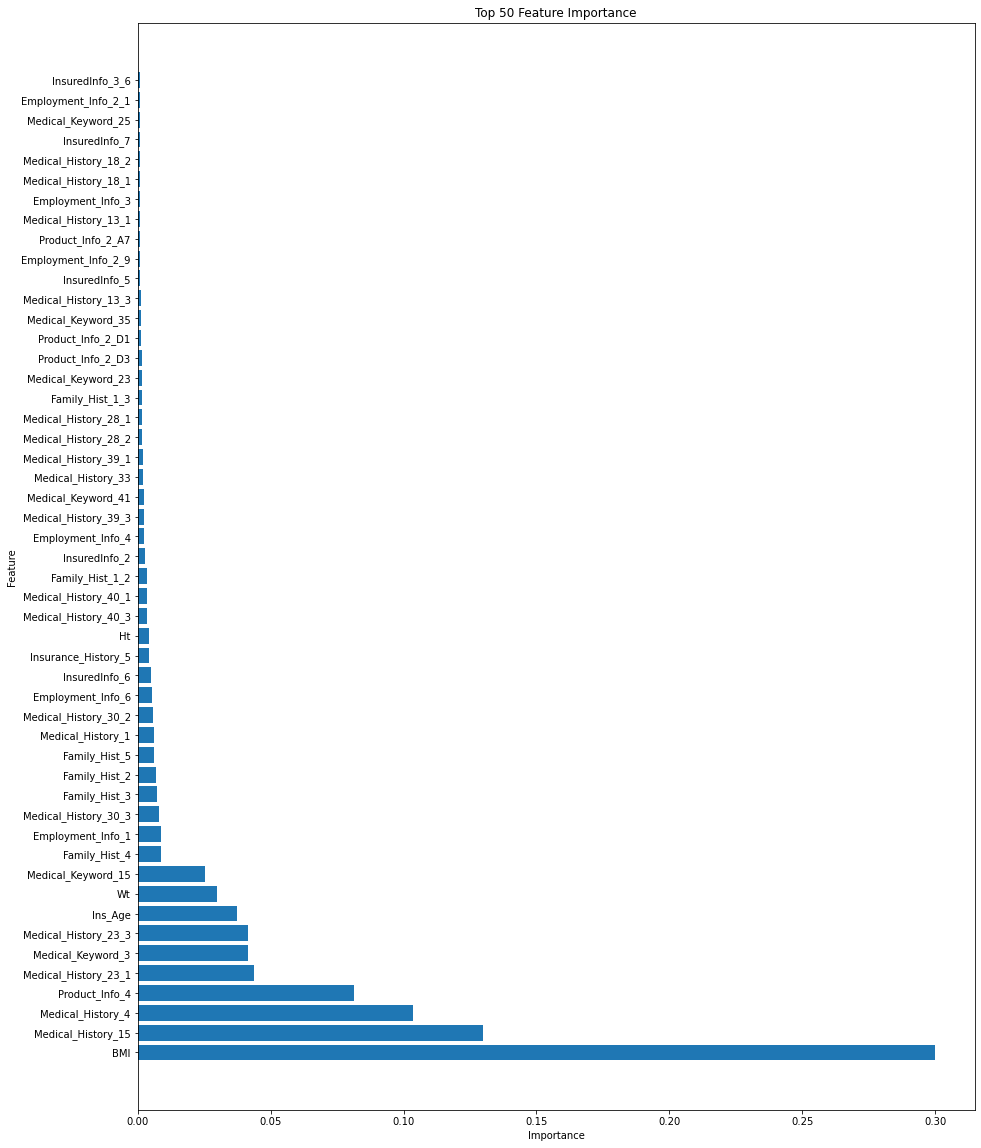

In [46]:
# set the number of features to show
num_features = 50

# set the figure size
plt.figure(figsize=(15, 20))

# create a horizontal bar chart
plt.barh(range(num_features), importancesRF[indicesRF][:num_features], align='center')

# set the y-tick labels
plt.yticks(range(num_features), X.columns[indicesRF][:num_features])

# set the axis labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Feature Importance'.format(num_features))

# show the plot
plt.show()

In [47]:
# Create an empty list to store the top feature names
top_feature_names = []

# Iterate over the top 100 features
for f in range(100):
    # Get the index of the f-th most important feature
    feature_index = indicesRF[f]
    # Get the name of the feature at that index
    feature_name = X.columns[feature_index]
    # Append the feature name to the list
    top_feature_names.append(feature_name)

<h1 style="color:blue"><b> Top Feature Dataset for Modeling</h1>

In [48]:
# Creating a new data frame containing the top 100 features, 'Id', and 'Response' variables
new_risk_data = risk_data[['Id', 'Response'] + top_feature_names].copy()

In [49]:
new_risk_data.head()

,Id,Response,BMI,Medical_History_15,Medical_History_4,Product_Info_4,Medical_History_23_1,Medical_Keyword_3,Medical_History_23_3,Ins_Age,...,Medical_History_6_1,Medical_History_2_491,InsuredInfo_3_2,InsuredInfo_3_11,Medical_History_2_3,Medical_History_2_16,Medical_Keyword_10,Product_Info_2_D4,Medical_History_36_2,Medical_History_7_1
0,2,8,0.323008,1.0,0,0.076923,0,0,1,0.641791,...,0,0,0,0,0,0,0,0,1,0
1,5,4,0.272288,0.0,0,0.076923,0,0,1,0.059701,...,0,0,0,0,0,0,0,0,1,0
2,6,8,0.428780,-999.0,1,0.076923,0,0,1,0.029851,...,0,0,0,0,1,0,0,0,0,0
3,7,8,0.352438,-999.0,1,0.487179,0,0,1,0.164179,...,0,0,0,0,0,0,0,1,1,0
4,8,8,0.424046,-999.0,1,0.230769,0,0,1,0.417910,...,0,0,0,0,0,0,0,0,0,0


In [50]:
new_risk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 102 entries, Id to Medical_History_7_1
dtypes: float64(15), int64(26), uint8(61)
memory usage: 22.0 MB


In [51]:
# Splitting the data into features and target variable
X = new_risk_data.drop(['Id', 'Response'], axis=1)
y = new_risk_data['Response']

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [52]:
# Set the directory to save the CSV files
dir_path = "C:\\Users\\brian\\Documents\\Data-Science-Cap-2\\CSV_Files"

# Create the directory if it does not exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Save the training and testing data to CSV files
X_train.to_csv(os.path.join(dir_path, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(dir_path, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(dir_path, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(dir_path,"y_test.csv"), index=False)

In [53]:
X.to_csv(os.path.join(dir_path,"X.csv"), index=False)
y.to_csv(os.path.join(dir_path,"y.csv"), index=False)

new_risk_data.to_csv(os.path.join(dir_path,"new_risk_data.csv"), index=False)